## Modeling Questions


* Calc AUC score to all models
* Save all charts to a folder

### With more time
* I SHOULD consider only doing features available to my predicted audience (no drinking/drugs).
* SMOAT Upsample and try running all models on that data.
  * **train_test_split STRATIFIED before SMOTE, then only SMOTE the train set?**
  * do new .ipynb doing SMOTE and sampling!

## F1 score algebraic derivation

Dana and I derived the following score. If D is the proportion of UNSUCCESSES or NOs in the Ground Truth, then a "monkey predicted" F1 Score, aka if a coin flip was used to categorize the info and split evenly by
how many Ground Truths there are, then: 

$$D=\frac{1-D}{1.5-D}$$

#### KNN
* Lazy
* Fits **fast**, predicts **slow**
* Fits d-dimensional data in `O(dn)` time
* Higher memory (saves entire data set)
* Various implementations (weighted, uniform)


In [13]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, Binarizer, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

# Helper Functions

In [14]:
target_names=['No','Yes']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix, Normalized')

In [15]:
def plot_roc_curve(fit_model, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.grid(which='major')
    plt.title(f"{title} ROC curve")
    s= 'AUC: ' + str(round(metrics.roc_auc_score(y_test, fit_model.predict(X_test)),3))
    plt.text(0.75, 0.25, s=s, ha='right', va='bottom', fontsize=14,
             bbox=dict(facecolor='grey', alpha=0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

In [16]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

# cut = np.linspace(0,1,100)
# cost = np.zeros_like(cut)
# from sklearn.model_selection import KFold, cross_val_predict
# obs = np.ravel(y)

# K = 20
# for j in range(K):
#     folds = KFold(n_splits=5,shuffle=True)
#     prob = cross_val_predict(logreg,X,np.ravel(y),cv=folds,method='predict_proba',n_jobs=5)[:,1]
#     getcost = makecost(obs,prob,falsepos_cost=20,falseneg_cost=25)
#     currentcost = getcost(cut)/X.shape[0]
#     cost += currentcost
#     plt.plot(cut, currentcost,c='C0',alpha=0.05)
# cost /= K
# plt.plot(cut,cost,c='C0')
# plt.xlabel('cutoff')
# plt.ylabel('Expected cost per data point');

In [17]:
def number_of_uniques(df):
    for i in df.columns:
        print(i,":", len(df[i].unique()))
        
def number_of_NaN(df):
    for i in df.columns:
        if df[i].isna().sum() != 0:
            print(i,":", df[i].isna().sum())

# Load Data

In [18]:
cupid = pd.read_hdf('data/cupid_cleaned.hd5', key='df', mode='r')
#cupid = load_pd_pkl('data/cupid_cleaned')

### Only:
* 14.65% of all single/available explicitly answered yes or no.
* 21.54% of all single/available answered yes/maybe/no
* 35.57% of all single/available explicitly stated if they had kids
* 8.27% of all single/available state they have one or more kid
### ?


In [19]:
# Create binary "wants_kids" YES vs NO from the more options
cupid['wants_kids_binary'] = ['yes' if x == 'yes' else 'no' if x == 'no' else np.nan for x in cupid['wants_kids']]
cupid['has_kids_options'] = ['one' if x == 'one' else 'multiple' if x == 'multiple' else 'no' if x == 'no' else np.nan for x in cupid['has_kids']]

cupid['status_available'] =  ['yes' if x == 'available' else 'yes' if x == 'single' else np.nan for x in cupid['status']]

In [20]:
target = ['wants_kids_binary']
continuous = ['age'] #, 'height']
# bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                     'religion_serious',

bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important', 
                  'religion_unserious', 'religion_laughing', 'religion_somewhat', 'religion_serious']


# remove from multi:  'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', , 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
#          'diet_intensity', 'diet_choice', 'religion_name'
                      
mult_categorical = ['orientation', 'status_available', 'has_kids_options',
                      'drinks', 'smokes', 'drugs', 'religion_name',]


# Assign feature groupings
columns = bi_categorical + mult_categorical + target

# Create DF of everything
df = cupid[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df['age'] = df.age.astype(float)

df = df.dropna()

# Split DF of only standardized/scaled features
scaled_features = df.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df.loc[:, columns], columns=columns, drop_first=False)
df = scaled_features.join(dummies)

# Drop all "placeholder" columns
df.drop(df.filter(regex='placeholder'), axis=1, inplace=True)


# Drop unused binary column
df.drop('has_kids_options_no', axis=1, inplace=True)
df.drop(columns=['status_available_yes', 'wants_kids_binary_no', 'sex_f','signs_important_matters a lot',
                 'religion_serious_very serious','orientation_straight','drinks_very often','smokes_yes',
                 'drugs_often','religion_name_other'], axis=1, inplace=True)


# SETUP MODELING DATA

X = df.drop('wants_kids_binary_yes', axis=1)
y = df['wants_kids_binary_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1375
Before OverSampling, counts of label '0': 752 

After OverSampling, the shape of train_X: (2750, 30)
After OverSampling, the shape of train_y: (2750,) 

After OverSampling, counts of label '1': 1375
After OverSampling, counts of label '0': 1375


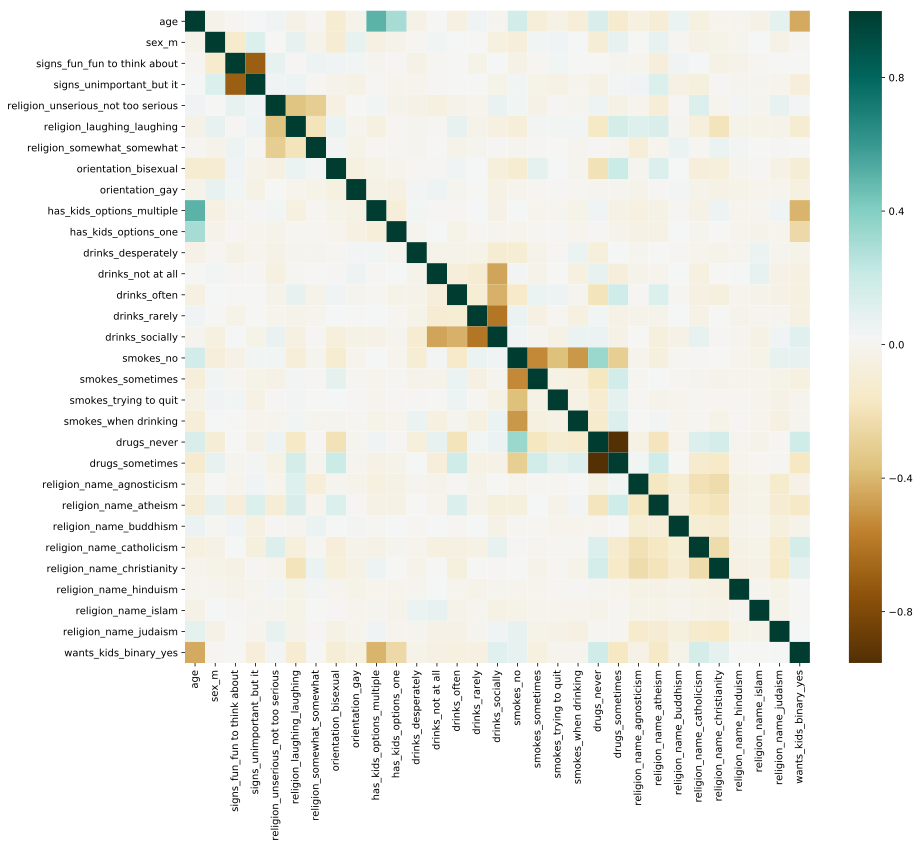

In [22]:
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(df.corr(), xticklabels=True, cmap='BrBG');

# K-Nearest Neighbors (KNN)

## GridSearchCV

### Warning, this is quite computationally heavy! (30+ minutes)


### A few RandomizedSearchCV searches helped me narrow the range to between K = 1-8. Both uniform and distance were the best results for weight.

In [23]:
knn = KNeighborsClassifier()

# define the parameter values that should be searched
#k_range = list(range(1, 7))
#weight_options = ['uniform', 'distance']

k_range = list(range(1,80))
# weight_options = ['uniform']
weight_options = ['uniform', 'distance']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# print(param_grid)

# instantiate the grid
grid_knn = RandomizedSearchCV(knn, param_grid, cv=10, scoring='roc_auc', n_jobs=-1, n_iter=100)

# fit the grid with data
grid_knn.fit(X_train, y_train)

# examine the best model
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

0.915095871441
{'weights': 'distance', 'n_neighbors': 9}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='distance')


In [24]:
grid_knn = grid_knn.best_estimator_

In [25]:
dir = 'AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models'

In [26]:
joblib.dump(grid_knn, f'{dir}/knn.joblib')  # Save model to disk

['AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models/knn.joblib']

In [27]:
y_pred_knn = grid_knn.predict(X_test)
print("test f1:", metrics.f1_score(y_test, y_pred_knn))
print("test roc_AUC:", metrics.roc_auc_score(y_test, y_pred_knn))
print("test accuracy:", metrics.accuracy_score(y_test, y_pred_knn))

test f1: 0.827467811159
test roc_AUC: 0.763657245581
test accuracy: 0.779605263158


In [28]:
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_knn),3))

AUC: 0.764


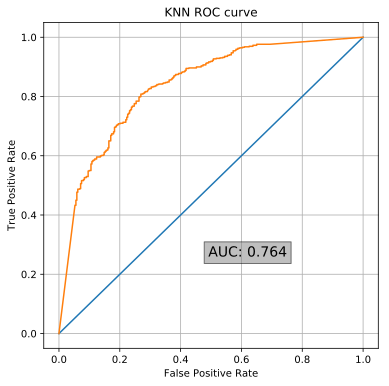

In [29]:
plot_roc_curve(grid_knn, 'KNN')

classification report: 

              precision    recall  f1-score   support

          No       0.68      0.71      0.69       323
         Yes       0.84      0.82      0.83       589

   micro avg       0.78      0.78      0.78       912
   macro avg       0.76      0.76      0.76       912
weighted avg       0.78      0.78      0.78       912

Confusion matrix, without normalization
[[229  94]
 [107 482]]
Normalized confusion matrix
[[ 0.71  0.29]
 [ 0.18  0.82]]


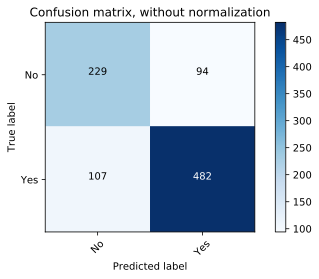

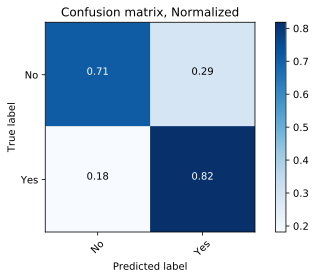

In [30]:
print("classification report: \n")
print(metrics.classification_report(y_test, y_pred_knn,target_names=target_names ))
confusion_matrices(y_pred_knn)

### Now messing with THRESHOLD

In [31]:
y_prob = grid_knn.predict_proba(X_test)

y_pred_knn_prob = y_prob[:,1] >= 0.7

print(metrics.classification_report(y_test, y_pred_knn_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_knn_prob))

              precision    recall  f1-score   support

          No       0.58      0.83      0.68       323
         Yes       0.88      0.67      0.76       589

   micro avg       0.73      0.73      0.73       912
   macro avg       0.73      0.75      0.72       912
weighted avg       0.77      0.73      0.73       912

accuracy:  0.728070175439


Confusion matrix, without normalization
[[267  56]
 [192 397]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.33  0.67]]


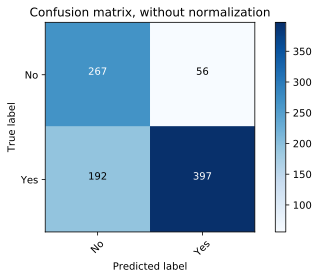

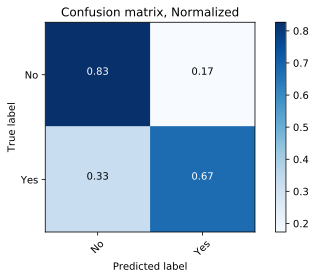

In [32]:
confusion_matrices(y_pred_knn_prob)

# Logistic Regression

In [33]:
logreg = LogisticRegression(max_iter=500, random_state=42)
# define the parameter values that should be searched
C_options = [0.5, 1, 2, 3]
duals = [False]
tol_options = [1e-3, 1e-2, 1e-1]
pen_options = ['l2']
solver_options = ['liblinear', 'sag', 'newton-cg', 'lbfgs']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_options, dual=duals, tol=tol_options, penalty=pen_options, solver=solver_options)
# print(param_grid)

# instantiate the grid
grid_lr = RandomizedSearchCV(logreg, param_grid, cv=10, scoring='roc_auc', n_jobs=6, n_iter=60)

# fit the grid with data
grid_lr.fit(X_train, y_train);

# examine the best model
print(grid_lr.best_score_)
print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 48 is smaller than n_iter=60. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.867331294539
{'tol': 0.001, 'solver': 'newton-cg', 'penalty': 'l2', 'dual': False, 'C': 2}
LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='newton-cg',
          tol=0.001, verbose=0, warm_start=False)


In [34]:
grid_lr = grid_lr.best_estimator_

In [35]:
joblib.dump(grid_lr, f'{dir}/logreg.joblib')  # Save model to disk

['AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models/logreg.joblib']

In [36]:
y_pred_logreg = grid_lr.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_logreg))

print(metrics.classification_report(y_test, grid_lr.predict(X_test)))
print(metrics.roc_auc_score(y_test, y_pred_logreg))


0.803728070175
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       323
           1       0.86      0.84      0.85       589

   micro avg       0.80      0.80      0.80       912
   macro avg       0.79      0.79      0.79       912
weighted avg       0.81      0.80      0.80       912

0.79072206132


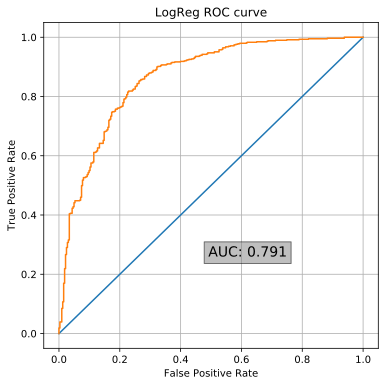

In [37]:
plot_roc_curve(grid_lr, "LogReg")

Confusion matrix, without normalization
[[241  82]
 [ 97 492]]
Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.16  0.84]]


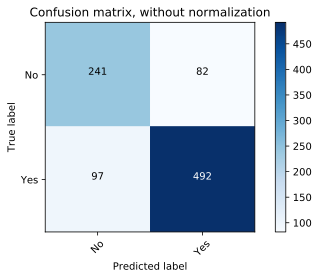

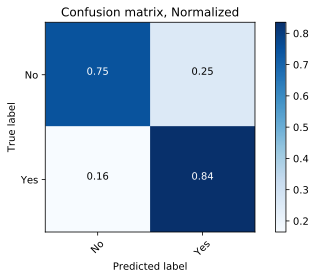

In [38]:
confusion_matrices(y_pred_logreg)

### Now messing with THRESHOLD

In [39]:
y_prob = grid_lr.predict_proba(X_test)

y_pred_lr_prob = y_prob[:,1] >= 0.4

print(metrics.classification_report(y_test, y_pred_lr_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_lr_prob))

              precision    recall  f1-score   support

          No       0.77      0.68      0.72       323
         Yes       0.84      0.89      0.86       589

   micro avg       0.82      0.82      0.82       912
   macro avg       0.80      0.79      0.79       912
weighted avg       0.81      0.82      0.81       912

accuracy:  0.815789473684


Confusion matrix, without normalization
[[220 103]
 [ 65 524]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.11  0.89]]


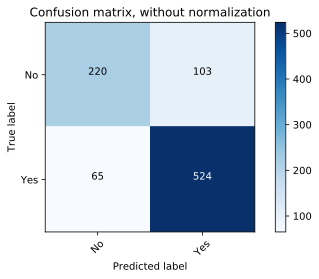

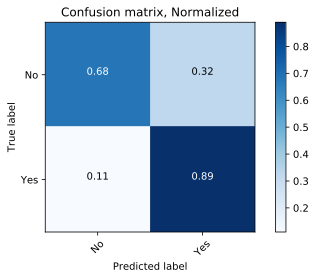

In [40]:
confusion_matrices(y_pred_lr_prob)

# Support Vector Machine (SVM)

In [41]:
svm = SVC(probability = True, random_state=42)

Cs=[0.5, 1, 1.5]
kernels = ['rbf', 'sigmoid', 'linear']
gammas = ['scale', 'auto']
tols = [1e-5, 1e-4, 1e-3, 1e-2]

# Cs=[.75, 1, 1.25, 1.5, 2]
# kernels = ['linear','rbf','sigmoid']
# gammas = ['scale', 'auto']
# tols = [.00001, .0001, .001, .01,]

param_grid = dict(C=Cs, tol=tols, gamma=gammas, kernel=kernels)

grid_svm = RandomizedSearchCV(svm, param_grid, cv=10, scoring='roc_auc', n_jobs=-1, n_iter=30)

grid_svm.fit(X_train, y_train)

print(grid_svm.best_score_)
print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

0.895609109181
{'tol': 0.0001, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.0001, verbose=False)


In [42]:
grid_svm = grid_svm.best_estimator_

In [43]:
y_pred_best_svm = grid_svm.predict(X_test)
print(metrics.roc_auc_score(y_test, y_pred_best_svm))
print(metrics.classification_report(y_test, y_pred_best_svm))

0.805852391891
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       323
           1       0.86      0.86      0.86       589

   micro avg       0.82      0.82      0.82       912
   macro avg       0.81      0.81      0.81       912
weighted avg       0.82      0.82      0.82       912



In [44]:
metrics.accuracy_score(y_test, y_pred_best_svm)

0.82236842105263153

In [45]:
joblib.dump(grid_svm, f'{dir}/SVM.joblib')  # Save model to disk

['AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models/SVM.joblib']

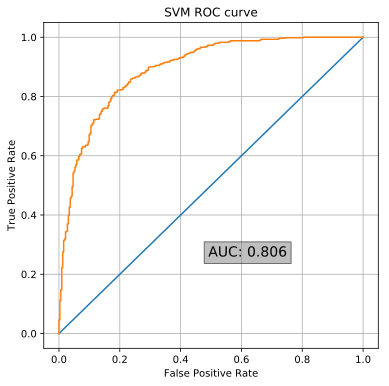

In [46]:
plot_roc_curve(grid_svm, 'SVM')

Confusion matrix, without normalization
[[242  81]
 [ 81 508]]
Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.14  0.86]]


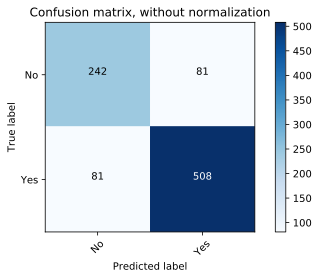

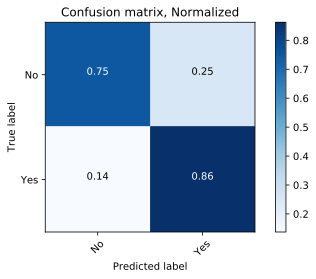

In [47]:
confusion_matrices(y_pred_best_svm)

### Now messing with THRESHOLD

In [48]:
y_prob = grid_svm.predict_proba(X_test)

y_pred_svm_prob = y_prob[:,1] > 0.4

print(metrics.classification_report(y_test, y_pred_svm_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_svm_prob))

              precision    recall  f1-score   support

          No       0.78      0.71      0.74       323
         Yes       0.85      0.89      0.87       589

   micro avg       0.83      0.83      0.83       912
   macro avg       0.81      0.80      0.80       912
weighted avg       0.82      0.83      0.82       912

accuracy:  0.825657894737


Confusion matrix, without normalization
[[228  95]
 [ 64 525]]
Normalized confusion matrix
[[ 0.71  0.29]
 [ 0.11  0.89]]


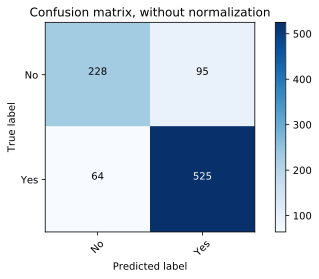

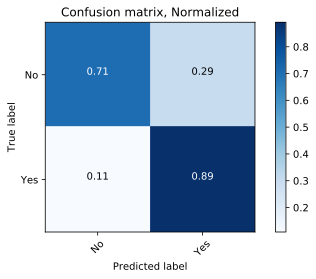

In [49]:
confusion_matrices(y_pred_svm_prob)

# Decision Trees

In [50]:
dt = DecisionTreeClassifier(random_state=42)

criterions = ['gini', 'entropy']    

param_grid = dict(criterion=criterions)

grid_dt = GridSearchCV(dt, param_grid, scoring='roc_auc', cv=10, n_jobs=-1)

grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)
print(grid_dt.best_estimator_)

0.805796235923
{'criterion': 'gini'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [51]:
grid_dt = grid_dt.best_estimator_

In [52]:
joblib.dump(grid_dt, f'{dir}/DecisionTree.joblib')  # Save model to disk

['AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models/DecisionTree.joblib']

In [53]:
y_pred_dtree = grid_dt.predict(X_test)
print('roc_auc:', metrics.roc_auc_score(y_test, y_pred_dtree))
print(metrics.classification_report(y_test, y_pred_dtree))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_dtree))

roc_auc: 0.741486068111
              precision    recall  f1-score   support

           0       0.64      0.69      0.67       323
           1       0.82      0.79      0.81       589

   micro avg       0.76      0.76      0.76       912
   macro avg       0.73      0.74      0.74       912
weighted avg       0.76      0.76      0.76       912

accuracy: 0.75548245614


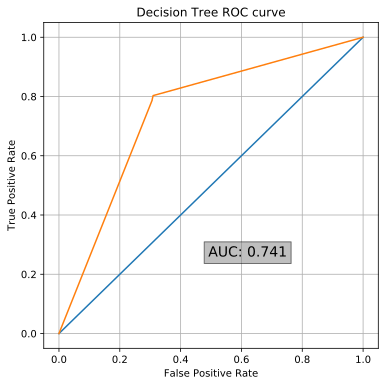

In [54]:
plot_roc_curve(grid_dt, "Decision Tree")

Confusion matrix, without normalization
[[224  99]
 [124 465]]
Normalized confusion matrix
[[ 0.69  0.31]
 [ 0.21  0.79]]


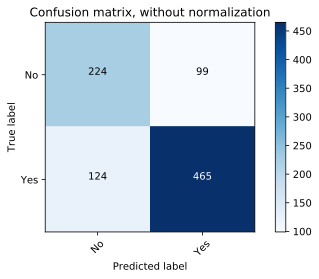

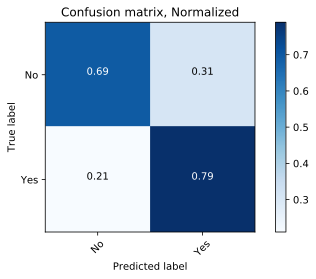

In [55]:
confusion_matrices(y_pred_dtree)

### Now messing with THRESHOLD - Nothing in Decision Tree matters.

In [56]:
y_prob = grid_dt.predict_proba(X_test)

y_pred_dt_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_dt_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_dt_prob))

              precision    recall  f1-score   support

          No       0.64      0.69      0.67       323
         Yes       0.82      0.79      0.81       589

   micro avg       0.76      0.76      0.76       912
   macro avg       0.73      0.74      0.74       912
weighted avg       0.76      0.76      0.76       912

accuracy:  0.75548245614


Confusion matrix, without normalization
[[224  99]
 [124 465]]
Normalized confusion matrix
[[ 0.69  0.31]
 [ 0.21  0.79]]


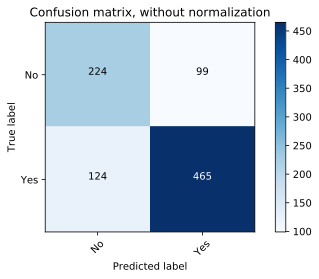

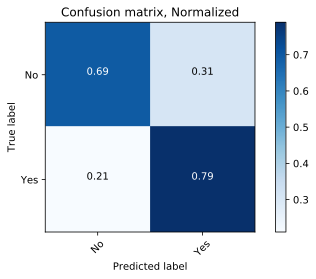

In [57]:
confusion_matrices(y_pred_dt_prob)

# Random Forrest

In [58]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini', 'entropy']
n_ests = [100, 300]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=10, n_jobs=-1)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

0.9356893146
{'criterion': 'entropy', 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [59]:
grid_rf = grid_rf.best_estimator_

In [60]:
joblib.dump(grid_rf, f'{dir}/RandomForest.joblib')  # Save model to disk

['AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models/RandomForest.joblib']

In [61]:
y_pred_rf = grid_rf.predict(X_test)
print('roc_auc:', metrics.roc_auc_score(y_test, y_pred_rf))
print(metrics.classification_report(y_test, y_pred_rf))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

roc_auc: 0.776989913113
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       323
           1       0.84      0.86      0.85       589

   micro avg       0.80      0.80      0.80       912
   macro avg       0.78      0.78      0.78       912
weighted avg       0.80      0.80      0.80       912

accuracy: 0.800438596491


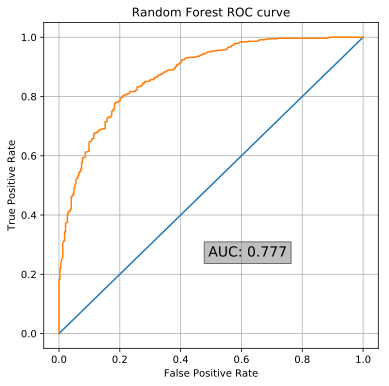

In [62]:
plot_roc_curve(grid_rf, "Random Forest")

Confusion matrix, without normalization
[[225  98]
 [ 84 505]]
Normalized confusion matrix
[[ 0.7   0.3 ]
 [ 0.14  0.86]]


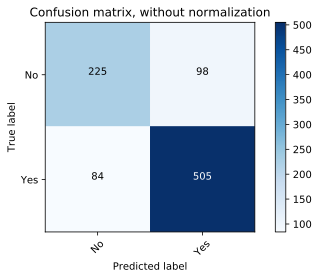

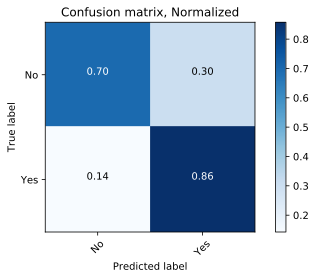

In [63]:
confusion_matrices(y_pred_rf)

### Now messing with THRESHOLD

In [64]:
y_prob = grid_rf.predict_proba(X_test)

y_pred_rf_prob = y_prob[:,1] > 0.35

print(metrics.classification_report(y_test, y_pred_rf_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_rf_prob))

              precision    recall  f1-score   support

          No       0.81      0.60      0.69       323
         Yes       0.81      0.92      0.86       589

   micro avg       0.81      0.81      0.81       912
   macro avg       0.81      0.76      0.77       912
weighted avg       0.81      0.81      0.80       912

accuracy:  0.808114035088


Confusion matrix, without normalization
[[193 130]
 [ 45 544]]
Normalized confusion matrix
[[ 0.6   0.4 ]
 [ 0.08  0.92]]


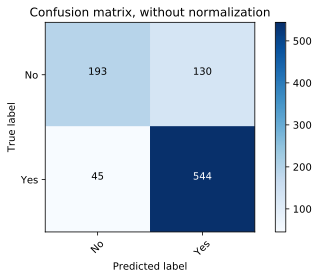

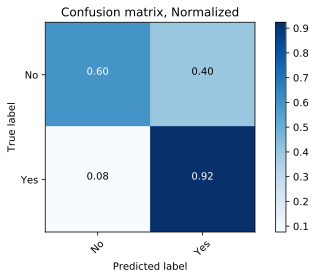

In [65]:
confusion_matrices(y_pred_rf_prob)

# Gradient Boosting

In [66]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance', 'exponential']
lrs = [.01, .05, .1, .5, 1]
n_ests = [50, 100, 200]
subsamples=[0.5, .75, 1]
maxd = [3,5]
tols = [1e-6, 1e-5, 1e-4, 1e-3]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = RandomizedSearchCV(gb, param_grid, scoring='roc_auc', cv=10, n_jobs=-1, n_iter=100)

grid_gb.fit(X_train, y_train)

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.936767529308
{'tol': 1e-06, 'subsample': 0.75, 'n_estimators': 200, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.05}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.75, tol=1e-06, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [67]:
grid_gb = grid_gb.best_estimator_
grid_gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.75, tol=1e-06, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [68]:
joblib.dump(grid_gb, f'{dir}/GradientBoosting.joblib')  # Save model to disk

['AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models/GradientBoosting.joblib']

In [69]:
y_pred_gb = grid_gb.predict(X_test)

metrics.f1_score(y_test, y_pred_gb)

0.8633333333333334

In [70]:
print(metrics.roc_auc_score(y_test, y_pred_gb))

0.795765504844


In [71]:
print(metrics.classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.76      0.71      0.74       323
           1       0.85      0.88      0.86       589

   micro avg       0.82      0.82      0.82       912
   macro avg       0.81      0.80      0.80       912
weighted avg       0.82      0.82      0.82       912



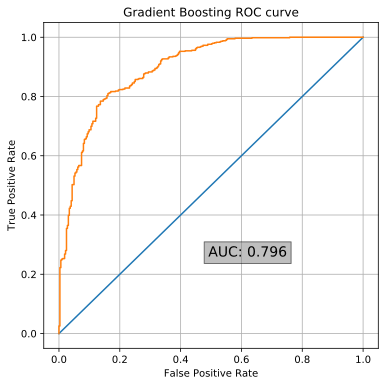

In [72]:
plot_roc_curve(grid_gb, "Gradient Boosting")

Confusion matrix, without normalization
[[230  93]
 [ 71 518]]
Normalized confusion matrix
[[ 0.71  0.29]
 [ 0.12  0.88]]


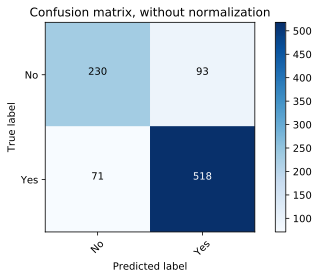

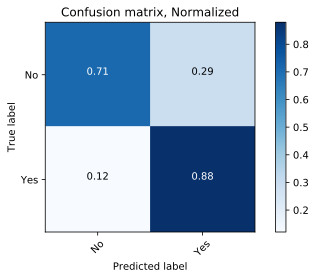

In [73]:
confusion_matrices(y_pred_gb)

### Now messing with THRESHOLD

In [74]:
y_prob = grid_gb.predict_proba(X_test)

y_pred_gb_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_gb_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_gb_prob))

              precision    recall  f1-score   support

          No       0.76      0.71      0.74       323
         Yes       0.85      0.88      0.86       589

   micro avg       0.82      0.82      0.82       912
   macro avg       0.81      0.80      0.80       912
weighted avg       0.82      0.82      0.82       912

accuracy:  0.820175438596


Confusion matrix, without normalization
[[230  93]
 [ 71 518]]
Normalized confusion matrix
[[ 0.71  0.29]
 [ 0.12  0.88]]


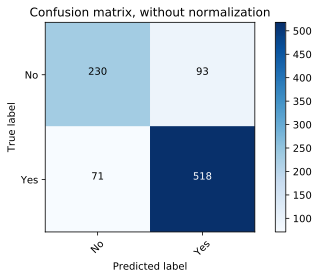

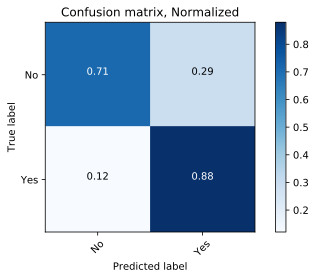

In [75]:
confusion_matrices(y_pred_gb_prob)

# Naive Bayes

In [76]:
bern = BernoulliNB()
bern.fit(X_train, y_train)
y_pred_bern = bern.predict(X_test)
metrics.roc_auc_score(y_test, y_pred_bern)

0.77738939378807548

In [77]:
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [78]:
joblib.dump(nb, f'{dir}/NaiveBayesGaussian.joblib')  # Save model to disk

['AUC_no_kids_DO_have_kids_SMOTE_reduced_features_models/NaiveBayesGaussian.joblib']

In [79]:
y_pred_nb = nb.predict(X_test)

In [80]:
metrics.roc_auc_score(y_test, y_pred_nb)

0.79027264556077104

In [81]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       323
           1       0.86      0.83      0.84       589

   micro avg       0.80      0.80      0.80       912
   macro avg       0.78      0.79      0.79       912
weighted avg       0.80      0.80      0.80       912



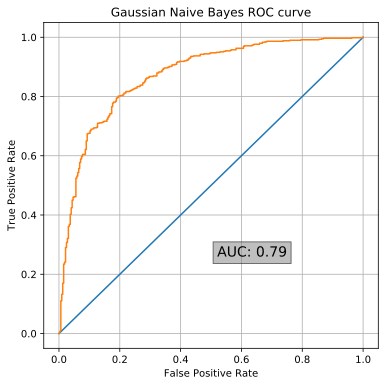

In [82]:
plot_roc_curve(nb, "Gaussian Naive Bayes")

Confusion matrix, without normalization
[[244  79]
 [103 486]]
Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.17  0.83]]


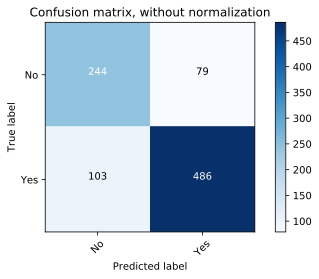

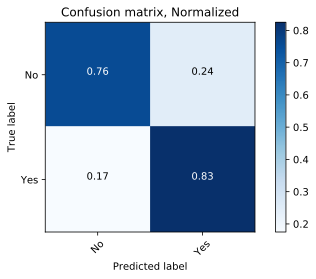

In [83]:
confusion_matrices(y_pred_nb)

### Now messing with THRESHOLD

In [84]:
y_prob = nb.predict_proba(X_test)

y_pred_nb_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_nb_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_nb_prob))

              precision    recall  f1-score   support

          No       0.70      0.76      0.73       323
         Yes       0.86      0.83      0.84       589

   micro avg       0.80      0.80      0.80       912
   macro avg       0.78      0.79      0.79       912
weighted avg       0.80      0.80      0.80       912

accuracy:  0.800438596491


Confusion matrix, without normalization
[[244  79]
 [103 486]]
Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.17  0.83]]


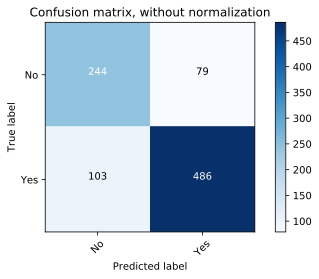

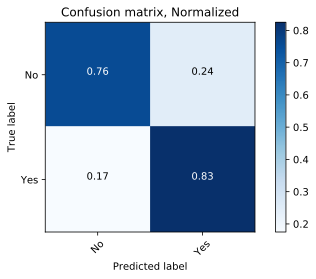

In [85]:
confusion_matrices(y_pred_nb_prob)

NameError: name 'new_x' is not defined

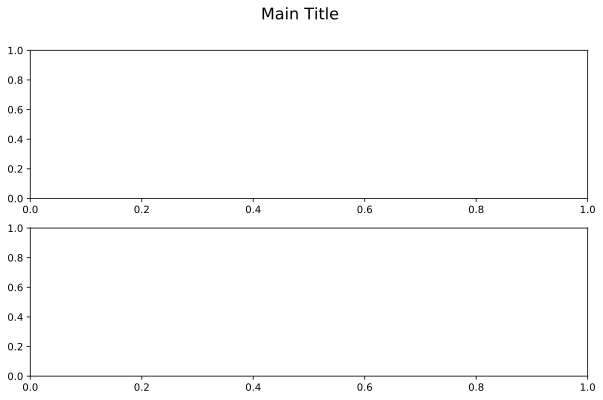

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
fig.set_figwidth(10)
fig.set_figheight(6)

fig.suptitle('Main Title',fontsize = 16)

ax[0].plot(new_x,new_y)
ax[0].set_title('Line Chart')

ax[1].bar(new_x,new_y)
ax[1].set_title('Bar Chart');